# Overview
In this notebook, model calibration STEPs 3-6 are demonstrated. This involves performing parameter estimation, then assessing the quality of both the optimization and the optimized model.

The model that is calibrated is taken from [Bruno et. al (2016)](https://academic.oup.com/jxb/article/67/21/5993/2738937), and has already been implemented in the systems biology model specification format [SBML](sbml.org/Main_Page). The parameter estimation problem has also already been formulated in [PEtab](https://github.com/PEtab-dev/PEtab), and is available in the [Benchmark Collection of Models in PEtab format](https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab/).

The parameter estimation problem, as specified in the PEtab format, includes the specification of many options, such as the bounds within which parameters should be estimated, the observation model that translates simulated model components into simulated measurements, and the measurements that simulations should be compared to.

# Problem Specification, Import, and Setup

In [1]:
# The PEtab problem is downloaded from the Benchmark Collection.

from pathlib import Path
def mkdir(path: Path):
    path.mkdir(parents=True, exist_ok=True)

output_path = Path('output')
mkdir(output_path)

model_name = 'Bruno_JExpBot2016'

output_path_models = output_path/'Benchmark-Models-PEtab'
petab_yaml_path = (
    Path('.') / '..' / 'Benchmark-Models-PEtab' / 'Benchmark-Models'/
    model_name / f'{model_name}.yaml'
)
if not petab_yaml_path.is_file():
    raise OSError('The PEtab YAML file does not exist.')

# PEtab problem
import petab
petab_problem = petab.Problem.from_yaml(str(petab_yaml_path))

import matplotlib.pyplot as plt

The PEtab format is compatible with a variety of tools that are primarily developed within the systems biology community. Here, the [pyPESTO](https://github.com/ICB-DCM/pyPESTO) tool is for model calibration. The default simulation tool used by pyPESTO is [AMICI](https://github.com/AMICI-dev/AMICI), which includes sensitivity analysis that allows for efficient gradient-based parameter estimation.

In [2]:
# The pyPESTO parameter estimation problem is created from the
# PEtab problem. The model is also compiled during import.

import pypesto.petab

# Import settings
output_path_import = output_path/'import'/model_name

# Import the PEtab problem and compile the model
pypesto_importer = pypesto.petab.PetabImporter(
    petab_problem,
    output_folder=str(output_path_import),
    model_name=model_name
)

# Setup the pyPESTO problem
pypesto_problem = pypesto_importer.create_problem()

Using existing amici model in folder output/import/Bruno_JExpBot2016.


# Parameter Estimation
A multi-start local optimization is used here, to efficiently explore the parameter space for optima. The [L-BFGS-B](https://epubs.siam.org/doi/abs/10.1137/0916069) method that is used here is generally suitable for a variety of optimization problems. The choice of number of starts is problem-specific.

In [3]:
# Optimization settings
import pypesto.engine
import pypesto.optimize
optimizer = pypesto.optimize.ScipyOptimizer(method='l-bfgs-b')
engine = pypesto.engine.MultiProcessEngine()
n_starts = 50

# Optimization
pypesto_result = pypesto.optimize.minimize(
    problem=pypesto_problem,
    optimizer=optimizer,
    n_starts=n_starts,
    engine=engine,
)

Engine set up to use up to 8 processes in total. The number was automatically determined and might not be appropriate on some systems.
Performing parallel task execution on 8 processes.
  0%|          | 0/50 [00:00<?, ?it/s]Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Executing task 2.
Executing task 14.
Executing task 6.
Executing task 12.
Executing task 0.
Executing task 4.
Executing task 8.
Executing task 10.
Final fval=3967.7051, time=0.1519s, n_fval=1.
Using existing amici mo

Executing task 48.
Final fval=588.4798, time=17.4255s, n_fval=281.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Final fval=2281.5863, time=6.5839s, n_fval=90.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Executing task 39.
Executing task 47.
Final fval=1278.6047, time=24.8224s, n_fval=238.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Executing task 37.
Final fval=-46.6882, time=16.0267s, n_fval=264.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Executing task 43.
Final fval=874.2012, time=10.7035s, n_fval=202.
Final fval=1458.1859, time=12.1979s, n_fval=139.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Executing task 45.
Final fval=3967.7051, time=0.2112s, n_fval=2.
Final fval=1540.7466, time=4.2658s, n_fval=56.
Final fval=1976.5099, time=9.4790s, n_fval=137.
Parameters obtained from history and optimizer do not match: [ 0.62555978  0.64741189  0.51874245  0.71742

# Assessment of Optimization
The first plot here is the waterfall plot, which shows the likelihood function value of the estimated parameter values at the end of each optimization run (start). The runs are ordered by likelihood function value. Generally, a plateau of a few starts at the minimum suggests a successful optimization with the good optima found. Color is used here to indicate plateaus (likelihood function values that are within `0.1` of each other).

The second plot is the parameters plot, which shows the estimated parameter values for each parameter at the end of each start. The vector of parameter values from a single start is indicated by connected dots. Here, the parameter vectors from the plateau at the minimum (colours in the waterfall and parameters plots correspond) are overlapping, which suggests that the parameter values are well-determined. As none of the values from the estimates in the minima touch the bounds, this suggests the bounds were appropriately chosen.

If the waterfall plot does not show a plateau at the minimum, the bounds can be adjusted (preferably to more realistic bounds), or the optimization can be run with a higher number of starts, or a different optimization method.

If any parameters from the parameter vectors from the plateau at the minimum touch the bounds, then the bounds can be adjusted.

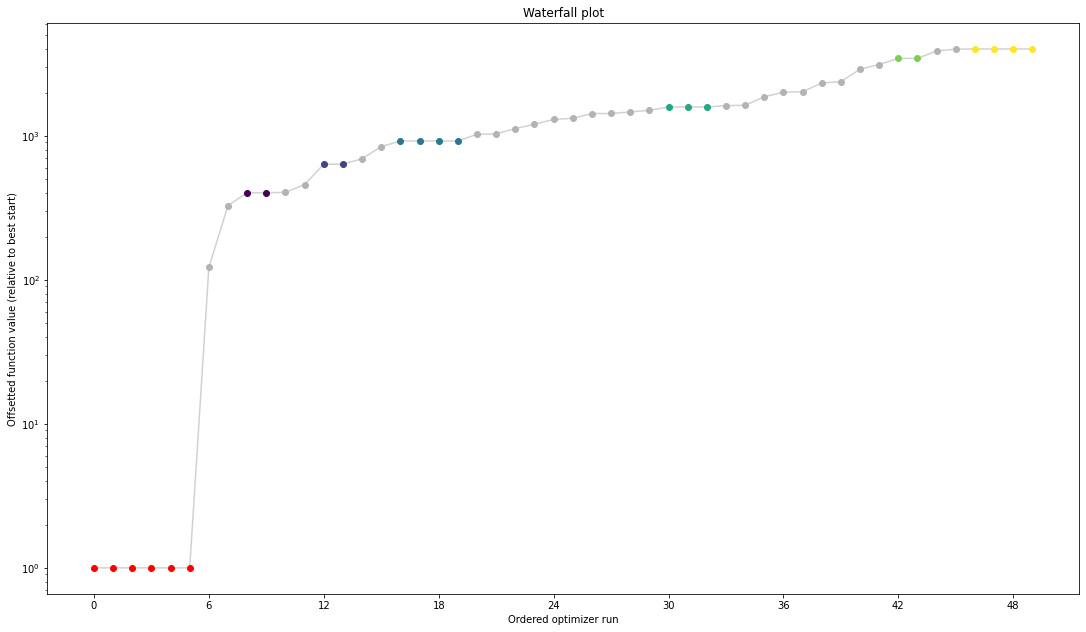

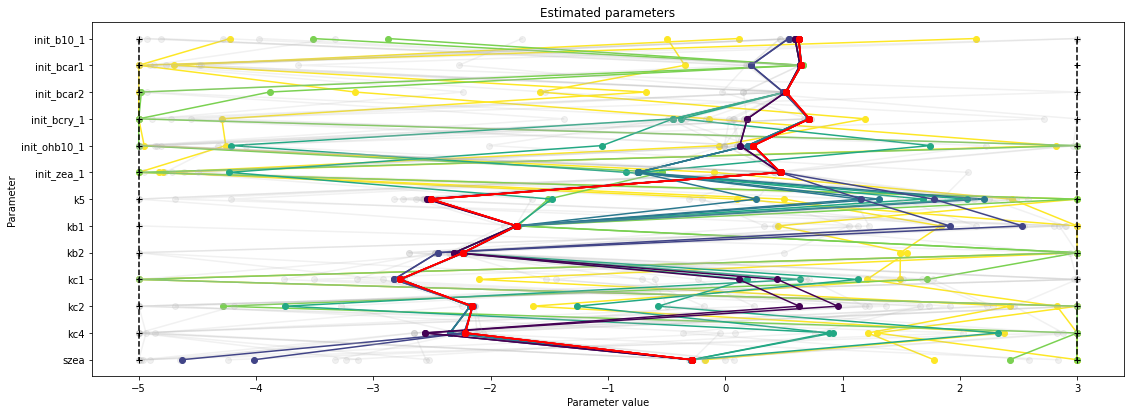

In [4]:
import pypesto.visualize

pypesto.visualize.waterfall(pypesto_result)
pypesto.visualize.parameters(pypesto_result);

# Assessment of Maximum Likelihood Estimate
Once optimization appears successful, the maximum likelihood estimate (MLE) can be assessed for parameter and prediction uncertainty.

Parameter uncertainty can be assessed with profile likelihoods, or MCMC sampling.

## Profile Likelihood
The [profile likelihood](https://academic.oup.com/bioinformatics/article/25/15/1923/213246) method involves repeatedly increasing and decreasing a single parameter in the MLE, and re-optimizing other parameters, until the likelihood drops below a certain ratio with respect to the MLE likelihood. The values that the parameter takes at the end of its profiling in both directions (increasing and decreasing) can be used to calculate confidence intervals for the parameter.

In [5]:
import pypesto.profile

# estimate profiling
pypesto_result = pypesto.profile.parameter_profile(
    problem=pypesto_problem,
    result=pypesto_result,
    optimizer=optimizer,
    engine=engine,
)

Performing parallel task execution on 8 processes.
  0%|          | 0/13 [00:00<?, ?it/s]Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Executing task 3.
Executing task 6.
Executing task 1.
Executing task 7.
Executing task 4.
Executing task 2.
Executing task 0.
Executing task 5.
Final fval=-46.6076, time=0.4636s, n_fval=14.
Final fval=-46.6169, time=1.5984s, n_fval=44.
Final fval=-46.6474, time=1.6521s, n_fval=45.
Final fval=-46.6205, time=1.9754s, n_fval=52.
Final fval=-46.6295, ti

Parameters obtained from history and optimizer do not match: [ 0.62438505  0.64198423  0.52274901  0.71344001  0.2214892   0.46830294
 -1.78970427 -2.23612815 -2.77317857 -2.16316881 -2.26325967 -0.26318376], [ 0.62438734  0.64198199  0.52274726  0.71343552  0.22148995  0.4683016
 -1.78970768 -2.23612766 -2.77317942 -2.16316749 -2.2632605  -0.26318701]
Final fval=-43.6968, time=2.6915s, n_fval=65.
Final fval=-46.1922, time=1.8001s, n_fval=42.
Final fval=-44.0428, time=1.7702s, n_fval=43.
Parameters obtained from history and optimizer do not match: [ 0.62609099  0.64759025  0.51879853  0.70821775  0.4692587  -2.52358644
 -1.77900697 -2.23198774 -2.76853599 -2.17284008 -2.33281746 -0.28672321], [ 0.62609067  0.64758961  0.51879798  0.70821401  0.46926085 -2.52358727
 -1.77900494 -2.2319837  -2.76853825 -2.17284525 -2.33283721 -0.2867281 ]
Final fval=-44.9296, time=3.5972s, n_fval=87.
Final fval=-43.7380, time=3.0993s, n_fval=74.
Final fval=-46.5832, time=1.5605s, n_fval=39.
Final fval=-4

Final fval=-46.5841, time=0.1500s, n_fval=6.
Final fval=-46.4272, time=0.2440s, n_fval=9.
Final fval=-45.0173, time=1.8165s, n_fval=62.
Parameters obtained from history and optimizer do not match: [ 0.62823635  0.64828135  0.51904345  0.69607419  0.20950152  0.46977047
 -2.51943602 -1.77847443 -2.22678941 -2.76401647 -2.29500292 -0.28693909], [ 0.62826137  0.64829879  0.51903982  0.69607714  0.20948746  0.46977642
 -2.51943107 -1.77845112 -2.22673779 -2.76401344 -2.29502956 -0.28697084]
Final fval=-43.6959, time=2.0459s, n_fval=72.
Final fval=-46.4275, time=1.1758s, n_fval=41.
Final fval=-46.1916, time=0.8788s, n_fval=31.
Final fval=-45.6331, time=2.2062s, n_fval=75.
Final fval=-44.0774, time=1.0488s, n_fval=38.
Parameters obtained from history and optimizer do not match: [ 0.64027403  0.6522503   0.5203967   0.71799227  0.23923412  0.47096074
 -2.50915193 -1.77534977 -2.76495051 -2.15830216 -2.2175157  -0.28839461], [ 0.64027036  0.65225552  0.52039867  0.71800788  0.23923391  0.47096

## Profile Likelihood Visualization
Here, plots of the profiles for each parameter are shown, and then their confidence intervals. In the profile plots, the ratio between the likelihood of the adjusted parameter value, and the MLE (blue) likelihood, is shown.

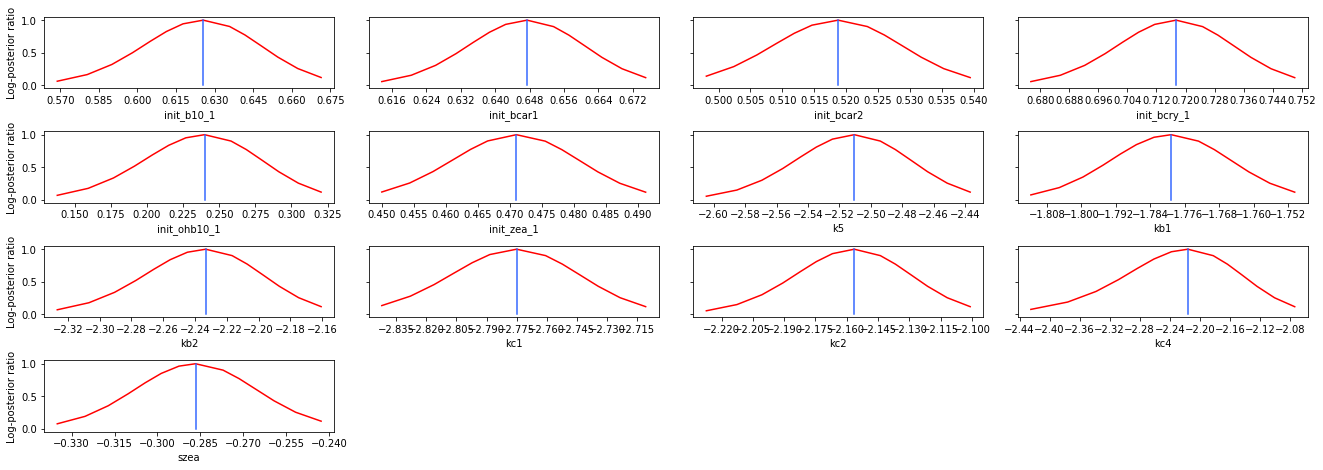

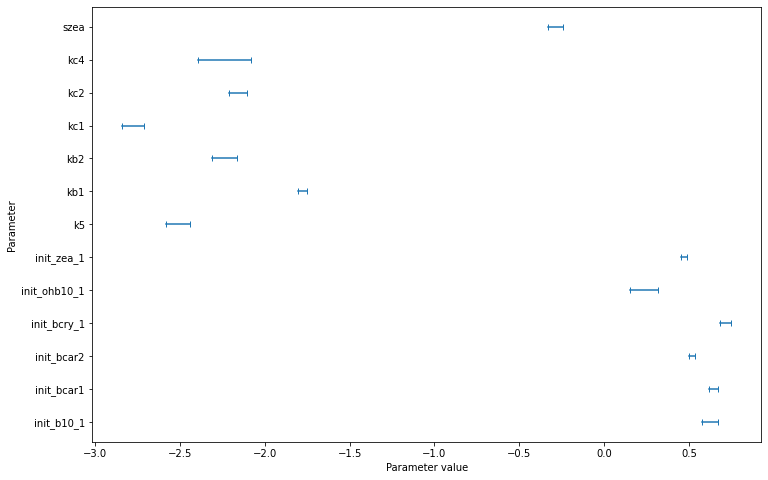

In [6]:
mle_color = [0.2, 0.4, 1, 1]
confidence_level = 0.95

reference = pypesto.visualize.create_references({
    'x': pypesto_result.optimize_result.list[0]['x'],
    'fval': pypesto_result.optimize_result.list[0]['fval'],
    'color': mle_color,
})

pypesto.visualize.profiles(pypesto_result, reference=reference)
fig, ax = plt.subplots(figsize=(12,8))
pypesto.visualize.profile_cis(
    pypesto_result,
    confidence_level=confidence_level,
    ax=ax,
);

## MCMC Sampling
MCMC sampling is another method of analysing the uncertainty of a parameter estimate. Here, the adaptive Metropolis-Hastings algorithm is used, with parallel tempering. To save computation time, only a small number of samples are requested, and plots generated with burn-in.

In [7]:
mle = pypesto_result.optimize_result.list[0]['x']

# Sampling settings
import pypesto.sample
n_samples = 1e4
internal_sampler = pypesto.sample.AdaptiveMetropolisSampler()
n_chains = 3
sampler = pypesto.sample.AdaptiveParallelTemperingSampler(
    internal_sampler=internal_sampler,
    n_chains=n_chains
)

# Sampling
pypesto_result = pypesto.sample.sample(
    pypesto_problem,
    n_samples,
    sampler,
    x0=mle,
)

100%|██████████| 10000/10000 [01:54<00:00, 87.03it/s]
Elapsed time: 130.048775024


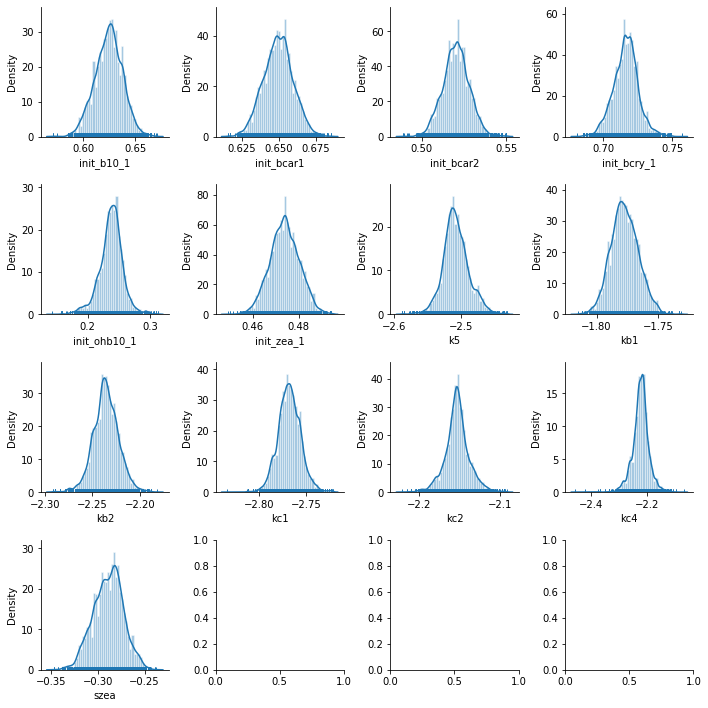

In [8]:
pypesto.visualize.sampling_1d_marginals(pypesto_result, size=(10, 10));

# Prediction Uncertainties for States and Observables
To assess prediction uncertainty, the MCMC samples are simulated as an ensemble, and state and observable trajectories for each sample are saved. Percentiles are then computed based on the ensemble predictions.

First, the prediction task is setup.

In [9]:
import numpy as np
from pypesto.ensemble import Ensemble, EnsembleType
from pypesto.predict.constants import AMICI_X, AMICI_Y

from _helpers_predict import get_amici_predictors

# Set custom timepoints for the simulation, so predictions are not only at measured timepoints.
plotting_objective = pypesto_problem.objective.set_custom_timepoints(
    timepoints_global=np.linspace(0, 180, 181),
)

predictor_state, predictor_observable = get_amici_predictors(plotting_objective)

ensemble = Ensemble.from_sample(
    pypesto_result,
    x_names=pypesto_result.problem.x_names,
    ensemble_type=EnsembleType.sample,
    lower_bound=pypesto_result.problem.lb,
    upper_bound=pypesto_result.problem.ub,
    # Only use a subset of the chain to reduce computation time
    chain_slice=slice(None, None, 100),
    # Burn-in is generally removed, but kept here as the chain is short and may
    # not have converged yet.
    remove_burn_in=False,
)

Next, state and observable predictions are made on the ensemble, then plotted.

In [10]:
prediction_states = ensemble.predict(
    predictor_state,
    prediction_id=AMICI_X,
    engine=engine,
)
prediction_states.compute_summary()

prediction_observables = ensemble.predict(
    predictor_observable,
    prediction_id=AMICI_Y,
    engine=engine,
)
prediction_observables.compute_summary();

Performing parallel task execution on 8 processes.
100%|██████████| 8/8 [00:00<00:00, 1513.23it/s]Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder output/import/Bruno_JExpBot2016.

Executing task 3.
Executing task 6.
Executing task 1.
Executing task 5.
Executing task 0.
Executing task 2.
Executing task 4.
Executing task 7.
Performing parallel task execution on 8 processes.
  0%|          | 0/8 [00:00<?, ?it/s]Using existing amici model in folder output/import/Bruno_JExpBot2016.
Using existing amici model in folder ou

State predictions.


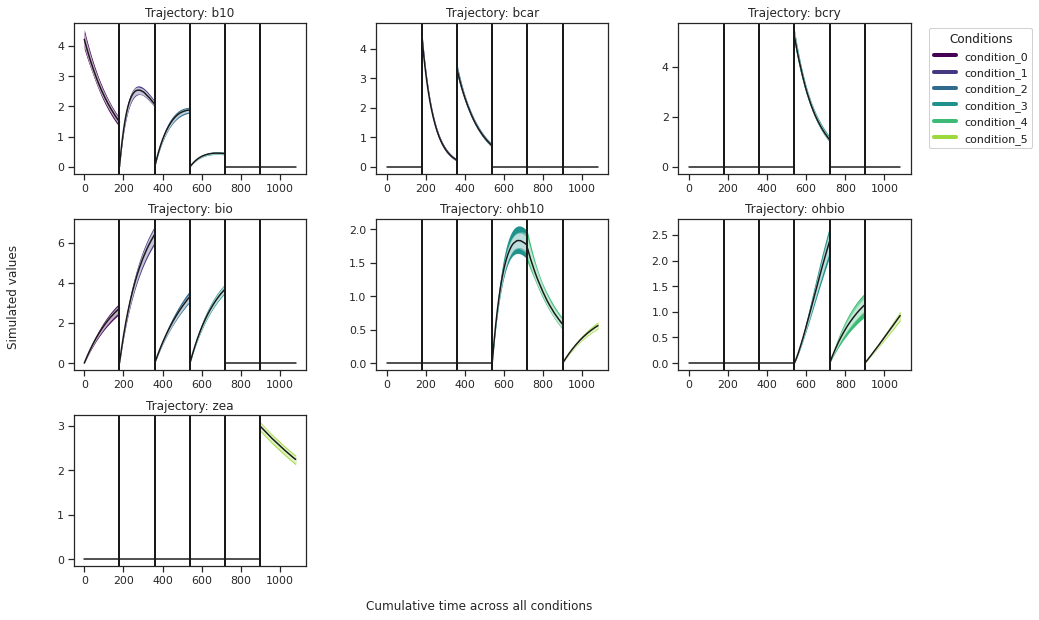

Observable predictions.


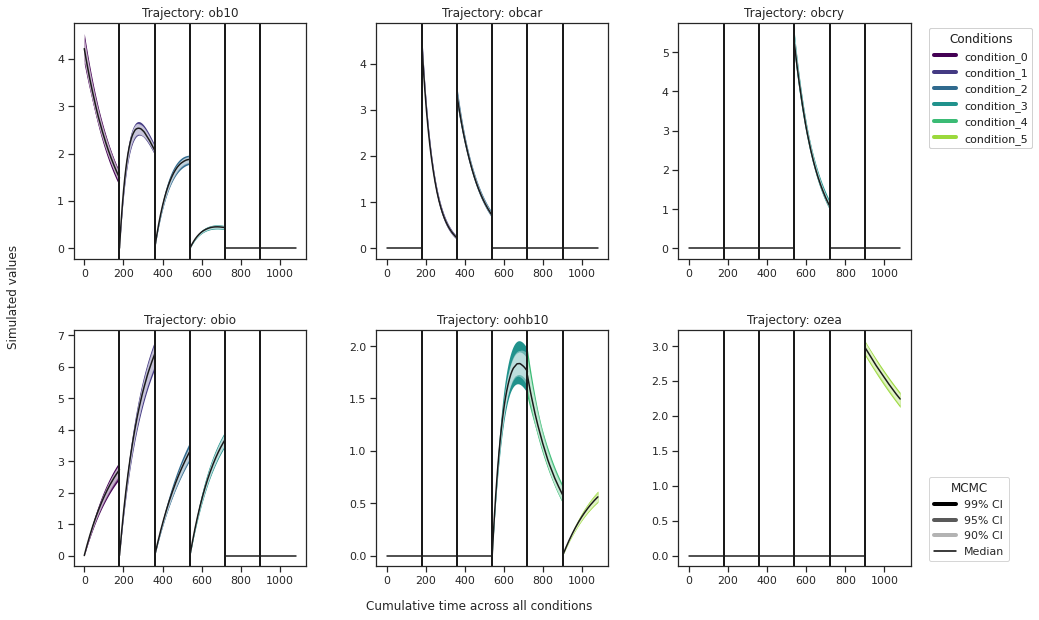

The "b10" state with the "condition_1" condition.


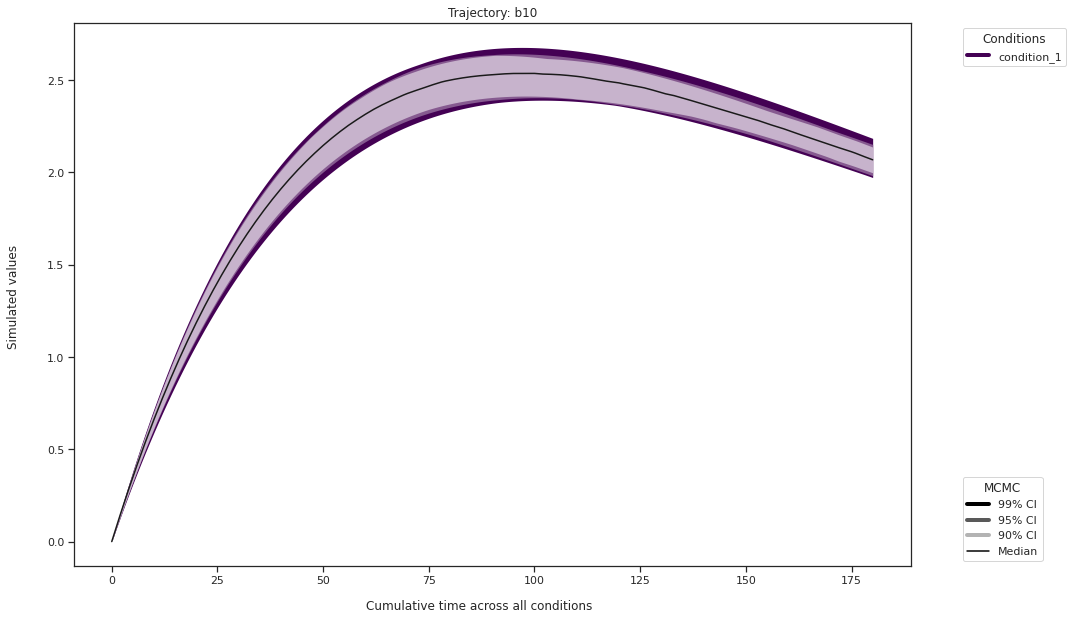

In [11]:
from pypesto.predict.constants import OUTPUT

credibility_interval_levels = [90, 95, 99]

plot_size = (15, 10)
axis_label_padding = 60

print('State predictions.')
pypesto.visualize.sampling_prediction_trajectories(
    prediction_states,
    levels=credibility_interval_levels,
    size=plot_size,
    axis_label_padding=axis_label_padding,
    groupby=OUTPUT,
)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

print('Observable predictions.')
pypesto.visualize.sampling_prediction_trajectories(
    prediction_observables,
    levels=credibility_interval_levels,
    size=plot_size,
    axis_label_padding=axis_label_padding,
    groupby=OUTPUT,
)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

print('The "b10" state with the "condition_1" condition.')
pypesto.visualize.sampling_prediction_trajectories(
    prediction_states,
    levels=credibility_interval_levels,
    size=plot_size,
    axis_label_padding=axis_label_padding,
    groupby=OUTPUT,
    output_ids=["b10"],
    condition_ids=["condition_1"]
)
plt.show()